In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github. /kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from glob import glob
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
base = MobileNetV2(input_shape = (128,128,3),include_top = False)
base = InceptionV3(input_shape = (128,128,3),include_top = False)

87910968/87910968 [==============================] - 0s 0us/step


In [4]:
x = base.output
x = Flatten()(x)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(1,activation='sigmoid')(x)

In [5]:
model = Model(base.input,x)

In [6]:
model.compile('adam','binary_crossentropy',['accuracy'])

In [7]:
imgs = []
lbls = []

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img,img_to_array
for i in glob('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/*/WithMask/*'):
  img = load_img(i,target_size = (128,128,3))
  img = img_to_array(img)
  imgs.append(img)
  lbls.append(1)

for i in glob('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/*/WithoutMask/*'):
  img = load_img(i,target_size = (128,128,3))
  img = img_to_array(img)
  imgs.append(img)
  lbls.append(0)

In [9]:
from sklearn.model_selection import train_test_split
imgs = np.array(imgs)
lbls = np.array(lbls)
trainx,testx,trainy,testy = train_test_split(imgs,lbls,stratify = lbls)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('chk',save_best_only=True)

In [11]:
hist = model.fit(trainx,trainy,validation_data=(testx,testy),epochs = 10,batch_size = 128,callbacks=[mc])

Epoch 1/10
70/70 [==============================] - 124s 979ms/step - loss: 0.1489 - accuracy: 0.9683 - val_loss: 0.6495 - val_accuracy: 0.8843
Epoch 2/10
70/70 [==============================] - 62s 888ms/step - loss: 0.0099 - accuracy: 0.9975 - val_loss: 0.0132 - val_accuracy: 0.9956
Epoch 3/10
70/70 [==============================] - 21s 302ms/step - loss: 0.0221 - accuracy: 0.9934 - val_loss: 0.6923 - val_accuracy: 0.8982
Epoch 4/10
70/70 [==============================] - 21s 295ms/step - loss: 0.0370 - accuracy: 0.9911 - val_loss: 58.4589 - val_accuracy: 0.9071
Epoch 5/10
70/70 [==============================] - 64s 925ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0122 - val_accuracy: 0.9969
Epoch 6/10
70/70 [==============================] - 21s 301ms/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.0193 - val_accuracy: 0.9949
Epoch 7/10
70/70 [==============================] - 21s 296ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0405 - val_accuracy: 0.99

In [12]:
valx = []
valy = []
for i in glob('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask/*'):
  img = load_img(i,target_size=(128,128,3))
  img = img_to_array(img)
  valx.append(img)
  valy.append(1)
for i in glob('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/*'):
  img = load_img(i,target_size=(128,128,3))
  img = img_to_array(img)
  valx.append(img)
  valy.append(0)
valx = np.array(valx)
valy = np.array(valy)

In [13]:
model.evaluate(valx,valy,steps = 30)

30/30 [==============================] - 3s 56ms/step - loss: 0.0046 - accuracy: 0.9987


[0.004570886958390474, 0.9987499713897705]

1/1 [==============================] - 0s 30ms/step


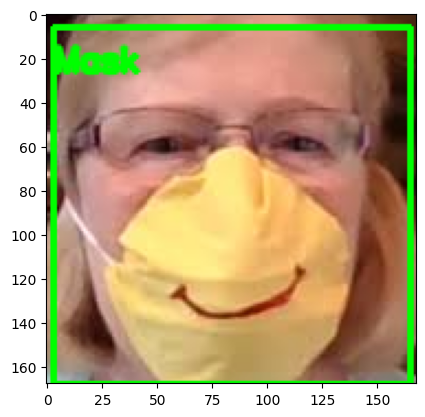

In [23]:
import cv2
import matplotlib.pyplot as plt

clf = cv2.CascadeClassifier('/kaggle/input/haarcascade-frontalface-alt/haarcascade_frontalface_alt.xml')
img = cv2.imread('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1174.png')

# Detect faces
boxes = clf.detectMultiScale(img, 1.01, 5)

# Process detected faces
for box in boxes:
    (x, y, w, h) = box
    im = img[y:y + h, x:x + w]
    im = cv2.resize(im, (128, 128))
    pred = model.predict(np.array([im]))
    
    if pred[0][0] < 0.5:
        label = 'No Mask'
        color = (0, 0, 255)  # Red color for "No Mask"
    else:
        label = 'Mask'
        color = (0, 255, 0)  # Green color for "Mask"

    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
    
    # Adjust the position of the text label
    text_x = x
    text_y = y - 20 if y - 20 > 20 else y + 20  

    cv2.putText(img, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

1/1 [==============================] - 0s 29ms/step


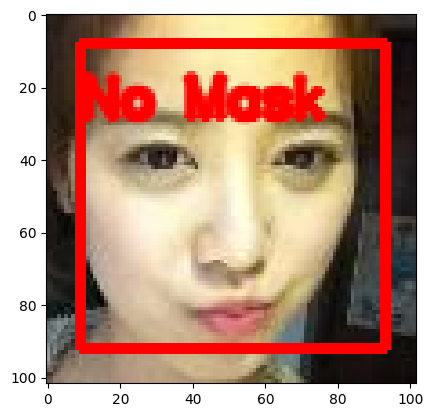

In [29]:
import cv2
import matplotlib.pyplot as plt

clf = cv2.CascadeClassifier('/kaggle/input/haarcascade-frontalface-alt/haarcascade_frontalface_alt.xml')
img = cv2.imread('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1029.png')

# Detect faces
boxes = clf.detectMultiScale(img, 1.01, 5)

# Process detected faces
for box in boxes:
    (x, y, w, h) = box
    im = img[y:y + h, x:x + w]
    im = cv2.resize(im, (128, 128))
    pred = model.predict(np.array([im]))
    
    if pred[0][0] < 0.5:
        label = 'No Mask'
        color = (0, 0, 255)  # Red color for "No Mask"
    else:
        label = 'Mask'
        color = (0, 255, 0)  # Green color for "Mask"

    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
    
    text_x = x
    text_y = y - 20 if y - 20 > 20 else y + 20 
    
    cv2.putText(img, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()